## RCSBをキーワード検索してPDBのリストを作成

In [3]:
from pypdb import *
q = input('keywords? ')
pdb_ids = Query(q).search()
# print('the number of PDB IDs are ' + str(len(pdb_ids)))
pdb_ids

/Users/keetane/opt/anaconda3/envs/bi2/lib/python3.10/site-packages/pypdb/util/http_requests.py:65: UserWarning: Too many failures on requests. Exiting...
  warnings.warn("Too many failures on requests. Exiting...")
/Users/keetane/opt/anaconda3/envs/bi2/lib/python3.10/site-packages/pypdb/pypdb.py:303: UserWarning: Retrieval failed, returning None
  warnings.warn("Retrieval failed, returning None")


In [4]:
pdb_ids

# Uniprotで標的を絞り込んでPDBリストを作成

In [27]:
# 調べたいタンパクのUniprotKB accession numberのリスト(一つでもOK)
keys = [
    'Q00987',
    # 'O60885', # BRD4_Human
    # 'Q9NXF7' # DCAF16
]

# ライブラリのimport
import pandas as pd
from Bio import SeqIO
from Bio.PDB import PDBList as pdbl
from urllib.request import urlopen

# 空のDataFrameを作成
summary = pd.DataFrame(index = keys, 
                       columns = ['name', 
                                  'description', 
                                  'pathway', 
                                #   'tissue', 
                                  'subcellularlocation', 
                                  'function', 
                                  'PDB count', 
                                  'PDB'])

# Uniprotにアクセスしてtableを作成
for keyword in keys:
    handle = urlopen("http://www.uniprot.org/uniprot/" + keyword + ".xml")
    record = SeqIO.read(handle, "uniprot-xml")
    dbx = record.dbxrefs
    dfIO = pd.DataFrame(dbx)
    df = dfIO[0].str.split(':', expand=True)
    df.columns = ['name', 'id', 'and']
    dfPDB = df[df['name']=='PDB']
    pdb_ids = list(dfPDB['id'])
    summary['name'][keyword] = record.name
    summary['description'][keyword] = record.description
#     summary['pathway'][keyword] = ''.join(record.annotations['comment_pathway'])
    # summary['tissue'][keyword] = ''.join(record.annotations['comment_tissuespecificity'])
    # summary['subcellularlocation'][keyword] = ', '.join(record.annotations['comment_subcellularlocation_location'])
    summary['function'][keyword] = ''.join(record.annotations['comment_function'])
    summary['PDB count'][keyword] = str(len(pdb_ids))
    summary['PDB'][keyword] = ', '.join(pdb_ids)
summary.T

,Q00987
name,MDM2_HUMAN
description,E3 ubiquitin-protein ligase Mdm2
pathway,NaN
subcellularlocation,NaN
function,E3 ubiquitin-protein ligase that mediates ubiq...
PDB count,140
PDB,"1RV1, 1T4E, 1T4F, 1YCR, 1Z1M, 2AXI, 2C6A, 2C6B..."


## PDBリストからリガンドを抜き出し、Supplier Listを作成

### 3 requests

In [26]:
import requests
import pubchempy as pcp
import pandas as pd

# Ligandの判定関数

def judge(entry_id):
    ligand_list = []
    query = '''
    {
    entry(entry_id:"''' + entry_id + '''") {
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
        entry_id
     }
    nonpolymer_comp {
        chem_comp {
        id
        type
        }
        pdbx_chem_comp_descriptor {
        descriptor
        type
        program
            }
        }
    }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()
    return(json_data['data']['entry']['nonpolymer_entities'])

# UNLやUNKの例外処理

def UNL_UNK(entry_id):
    ligand_list = []

    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()

    return(json_data['data']['entry']['nonpolymer_entities'][0]['nonpolymer_comp']['pdbx_chem_comp_descriptor'])

# PDB IDからリガンドリストを作成

def entry_to_ligand(entry_id):

    ligand_list = []
    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
      rcsb_id
    struct {
      title
    }
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()
    for i in json_data.get('data').get('entry').get('nonpolymer_entities'):
        entry_id = i.get('rcsb_nonpolymer_entity_container_identifiers')
        nonpolymer_comp = i.get('nonpolymer_comp')
        ligand_id = nonpolymer_comp.get('chem_comp').get('id')
        for data in nonpolymer_comp.get('pdbx_chem_comp_descriptor'):
            if (data.get('type') == "InChI") and (data.get('program') == "InChI"):
                inchi = [data.get('descriptor')]
                type = [data.get('type')]
                program = [data.get('program')]
                d = {'Ligand_ID':ligand_id, 'InChI':inchi}
                ligand_list.append(d)
            df = pd.DataFrame(ligand_list)
            df['Title'] = json_data['data']['entry']['struct']['title']
    return(df)

# ここからfor文

# pdb_ids = ['5UT2', '4FVR'] # for test
cols = ['Ligand_ID', 'SMILES', 'InChI', 'CID', 'MW', 'PDB_ID', 'Title', 'Supplier', 'RCSB_URL', 'Ligand_URL']
Sup_List = pd.DataFrame(columns = cols)

for pdb_id in pdb_ids:

    # Ligandがない場合の例外処理
    if judge(pdb_id) != None:
        if UNL_UNK(pdb_id) != None:

            # DataFrameの作成
            df = pd.DataFrame(entry_to_ligand(pdb_id))

            df['PDB_ID'] = pdb_id
            df['CID'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['CID']).astype(str)
            df['MW'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['MolecularWeight']).astype(float)
            df['SMILES'] =  df['InChI'].map(lambda x : pcp.get_properties('IsomericSMILES', x, 'inchi')[0]['IsomericSMILES'])
            df['Title'] =  df['PDB_ID'].map(lambda x : title(x))

            # リンクの作成
            df['Supplier'] = df['CID'].map(lambda x : 'https://pubchem.ncbi.nlm.nih.gov/compound/' + x + '#section=Chemical-Vendors&fullscreen=true')
            df['RCSB_URL'] = df['PDB_ID'].map(lambda x : 'https://www.rcsb.org/structure/' + x)
            df['Ligand_URL'] = df['Ligand_ID'].map(lambda x : 'https://www.rcsb.org/ligand/' + x)
            # df['Title'] = json_data['data']['entry']['struct']['title']

            # df結合
            Sup_List = pd.concat([Sup_List, df])
        else:
            df = pd.DataFrame(columns=cols)
            empty = []
            empty.append(pdb_id)
            df['PDB_ID'] = empty
            df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])
    else:
        df = pd.DataFrame(columns=cols)
        empty = []
        empty.append(pdb_id)
        df['PDB_ID'] = empty
        df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])

Sup_List = Sup_List.reset_index(drop=True)

KeyboardInterrupt: 

### 1 request

In [203]:
%%timeit
import requests
import pubchempy as pcp
import pandas as pd

# Ligandの有無を判定してdfを作成する関数

def PDB2L(entry_id):
    ligand_list = []

    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
      rcsb_id
    struct {
      title
    }
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()

    # dfの作成
    # Ligandがある場合だけrun
    if json_data['data']['entry']['nonpolymer_entities'] != None:
        # LigandがUNLやUNKではない時はrun
        if json_data['data']['entry']['nonpolymer_entities'][0]['nonpolymer_comp']['pdbx_chem_comp_descriptor'] != None:
            # 複数のリガンドをdfに代入
            for i in json_data.get('data').get('entry').get('nonpolymer_entities'):
                entry_id = i.get('rcsb_nonpolymer_entity_container_identifiers')
                nonpolymer_comp = i.get('nonpolymer_comp')
                ligand_id = nonpolymer_comp.get('chem_comp').get('id')
                for data in nonpolymer_comp.get('pdbx_chem_comp_descriptor'):
                    if (data.get('type') == "InChI") and (data.get('program') == "InChI"):
                        inchi = [data.get('descriptor')]
                        type = [data.get('type')]
                        program = [data.get('program')]
                        d = {'Ligand_ID':ligand_id, 'InChI':inchi}
                        ligand_list.append(d)
                    df = pd.DataFrame(ligand_list)
                    df['Title'] = json_data['data']['entry']['struct']['title']
        return(df)

# ここからfor文

# pdb_ids = ['5UT2', '4FVR'] # for test
cols = ['Ligand_ID', 'SMILES', 'InChI', 'CID', 'MW', 'PDB_ID', 'Title', 'Supplier', 'RCSB_URL', 'Ligand_URL']
Sup_List = pd.DataFrame(columns = cols)

for pdb_id in pdb_ids:

    # Ligandがない場合の例外処理
    if judge(pdb_id) != None:
        if UNL_UNK(pdb_id) != None:

            # DataFrameの作成
            df = pd.DataFrame(entry_to_ligand(pdb_id))

            df['PDB_ID'] = pdb_id
            df['CID'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['CID']).astype(str)
            df['MW'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['MolecularWeight']).astype(float)
            df['SMILES'] =  df['InChI'].map(lambda x : pcp.get_properties('IsomericSMILES', x, 'inchi')[0]['IsomericSMILES'])
            df['Title'] =  df['PDB_ID'].map(lambda x : title(x))

            # リンクの作成
            df['Supplier'] = df['CID'].map(lambda x : 'https://pubchem.ncbi.nlm.nih.gov/compound/' + x + '#section=Chemical-Vendors&fullscreen=true')
            df['RCSB_URL'] = df['PDB_ID'].map(lambda x : 'https://www.rcsb.org/structure/' + x)
            df['Ligand_URL'] = df['Ligand_ID'].map(lambda x : 'https://www.rcsb.org/ligand/' + x)
            # df['Title'] = json_data['data']['entry']['struct']['title']

            # df結合
            Sup_List = pd.concat([Sup_List, df])
        else:
            df = pd.DataFrame(columns=cols)
            empty = []
            empty.append(pdb_id)
            df['PDB_ID'] = empty
            df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])
    else:
        df = pd.DataFrame(columns=cols)
        empty = []
        empty.append(pdb_id)
        df['PDB_ID'] = empty
        df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])

Sup_List = Sup_List.reset_index(drop=True)

2min 9s ± 5.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## MW>150, Duplicateを除去

In [13]:
Sup_List_Dup = Sup_List[Sup_List['MW']>150].drop_duplicates('Ligand_ID').reset_index(drop=True)
Sup_List_Dup

,Ligand_ID,SMILES,InChI,CID,MW,PDB_ID,Title,Supplier,RCSB_URL,Ligand_URL
0,YK3,CCS(=O)(=O)NC1=CC=C(C=C1)C2=N[C@H](C3=NN=C(N3C...,"[InChI=1S/C25H31N5O4S2/c1-8-36(32,33)29-18-11-...",166642338,529.7,8G46,Cryo-EM structure of DDB1deltaB-DDA1-DCAF16-BR...,https://pubchem.ncbi.nlm.nih.gov/compound/1666...,https://www.rcsb.org/structure/8G46,https://www.rcsb.org/ligand/YK3
1,U79,CC1=C2C(=CNC2=C(C=C1)NS(=O)(=O)C3=CC=C(C=C3)CN...,[InChI=1S/C44H38N8O5S2/c1-24-6-19-35(41-38(24)...,156822078,823.0,8OV6,Ternary structure of intramolecular bivalent g...,https://pubchem.ncbi.nlm.nih.gov/compound/1568...,https://www.rcsb.org/structure/8OV6,https://www.rcsb.org/ligand/U79


## 構造を表示

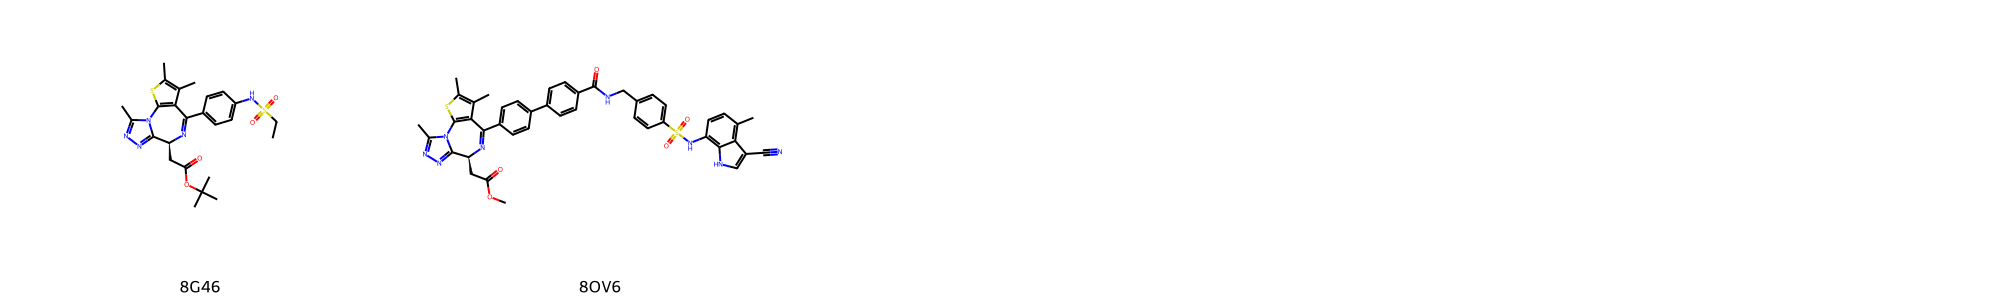

In [22]:
from rdkit.Chem import Draw
from rdkit import Chem

Sup_List_Dup['Mol'] = Sup_List_Dup['SMILES'].map(lambda x : Chem.MolFromSmiles(x))
Draw.MolsToGridImage(
                    Sup_List_Dup['Mol'],
                    molsPerRow=5,
                    subImgSize=(400,300),
                    legends=list(Sup_List_Dup['PDB_ID'])
                    )


In [184]:
import requests
import pubchempy as pcp
import pandas as pd

# Ligandの判定関数

def judge(entry_id):
    ligand_list = []
    query = '''
    {
    entry(entry_id:"''' + entry_id + '''") {
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
        entry_id
     }
    nonpolymer_comp {
        chem_comp {
        id
        type
        }
        pdbx_chem_comp_descriptor {
        descriptor
        type
        program
            }
        }
    }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()
    return(json_data['data']['entry']['nonpolymer_entities'])

# UNLやUNKの例外処理

def UNL_UNK(entry_id):
    ligand_list = []

    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()

    return(json_data['data']['entry']['nonpolymer_entities'][0]['nonpolymer_comp']['pdbx_chem_comp_descriptor'])

# PDB IDからリガンドリストを作成

def entry_to_ligand(entry_id):

    ligand_list = []
    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
      rcsb_id
    struct {
      title
    }
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()
    for i in json_data.get('data').get('entry').get('nonpolymer_entities'):
        entry_id = i.get('rcsb_nonpolymer_entity_container_identifiers')
        nonpolymer_comp = i.get('nonpolymer_comp')
        ligand_id = nonpolymer_comp.get('chem_comp').get('id')
        for data in nonpolymer_comp.get('pdbx_chem_comp_descriptor'):
            if (data.get('type') == "InChI") and (data.get('program') == "InChI"):
                inchi = [data.get('descriptor')]
                type = [data.get('type')]
                program = [data.get('program')]
                d = {'Ligand_ID':ligand_id, 'InChI':inchi}
                ligand_list.append(d)
            df = pd.DataFrame(ligand_list)
            df['Title'] = json_data['data']['entry']['struct']['title']
    return(df)

# ここからfor文

pdb_list = ['5UT2', '4FVR']
cols = ['Ligand_ID', 'SMILES', 'InChI', 'CID', 'MW', 'PDB_ID', 'Title', 'Supplier', 'RCSB_URL', 'Ligand_URL']
Sup_List = pd.DataFrame(columns = cols)

for pdb_id in pdb_list:

    # Ligandがない場合の例外処理
    if judge(pdb_id) != None:
        if UNL_UNK(pdb_id) != None:

            # DataFrameの作成
            df = pd.DataFrame(entry_to_ligand(pdb_id))

            df['PDB_ID'] = pdb_id
            df['CID'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['CID']).astype(str)
            df['MW'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['MolecularWeight']).astype(float)
            df['SMILES'] =  df['InChI'].map(lambda x : pcp.get_properties('IsomericSMILES', x, 'inchi')[0]['IsomericSMILES'])
            df['Title'] =  df['PDB_ID'].map(lambda x : title(x))

            # リンクの作成
            df['Supplier'] = df['CID'].map(lambda x : 'https://pubchem.ncbi.nlm.nih.gov/compound/' + x + '#section=Chemical-Vendors&fullscreen=true')
            df['RCSB_URL'] = df['PDB_ID'].map(lambda x : 'https://www.rcsb.org/structure/' + x)
            df['Ligand_URL'] = df['Ligand_ID'].map(lambda x : 'https://www.rcsb.org/ligand/' + x)
            # df['Title'] = json_data['data']['entry']['struct']['title']

            # df結合
            Sup_List = pd.concat([Sup_List, df])
        else:
            df = pd.DataFrame(columns=cols)
            empty = []
            empty.append(pdb_id)
            df['PDB_ID'] = empty
            df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])
    else:
        df = pd.DataFrame(columns=cols)
        empty = []
        empty.append(pdb_id)
        df['PDB_ID'] = empty
        df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])

Sup_List = Sup_List.reset_index(drop=True)

In [194]:
Sup_List

,Ligand_ID,SMILES,InChI,CID,MW,PDB_ID,Title,Supplier,RCSB_URL,Ligand_URL
0,GOL,C(C(CO)O)O,"[InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2]",753,92.090,5UT2,JAK2 JH2 in complex with PRT062607,https://pubchem.ncbi.nlm.nih.gov/compound/753#...,https://www.rcsb.org/structure/5UT2,https://www.rcsb.org/ligand/GOL
1,3YT,C1CC[C@H]([C@H](C1)N)NC2=NC=C(C(=N2)NC3=CC(=CC...,[InChI=1S/C19H23N9O/c20-15-6-1-2-7-16(15)26-19...,44462758,393.400,5UT2,JAK2 JH2 in complex with PRT062607,https://pubchem.ncbi.nlm.nih.gov/compound/4446...,https://www.rcsb.org/structure/5UT2,https://www.rcsb.org/ligand/3YT
2,ACT,CC(=O)[O-],"[InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1]",175,59.040,5UT2,JAK2 JH2 in complex with PRT062607,https://pubchem.ncbi.nlm.nih.gov/compound/175#...,https://www.rcsb.org/structure/5UT2,https://www.rcsb.org/ligand/ACT
3,GOL,C(C(CO)O)O,"[InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2]",753,92.090,5UT2,JAK2 JH2 in complex with PRT062607,https://pubchem.ncbi.nlm.nih.gov/compound/753#...,https://www.rcsb.org/structure/5UT2,https://www.rcsb.org/ligand/GOL
4,3YT,C1CC[C@H]([C@H](C1)N)NC2=NC=C(C(=N2)NC3=CC(=CC...,[InChI=1S/C19H23N9O/c20-15-6-1-2-7-16(15)26-19...,44462758,393.400,5UT2,JAK2 JH2 in complex with PRT062607,https://pubchem.ncbi.nlm.nih.gov/compound/4446...,https://www.rcsb.org/structure/5UT2,https://www.rcsb.org/ligand/3YT
5,ACT,CC(=O)[O-],"[InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1]",175,59.040,5UT2,JAK2 JH2 in complex with PRT062607,https://pubchem.ncbi.nlm.nih.gov/compound/175#...,https://www.rcsb.org/structure/5UT2,https://www.rcsb.org/ligand/ACT
6,ATP,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,5957,507.180,4FVR,Crystal structure of the Jak2 pseudokinase dom...,https://pubchem.ncbi.nlm.nih.gov/compound/5957...,https://www.rcsb.org/structure/4FVR,https://www.rcsb.org/ligand/ATP
7,MG,[Mg+2],[InChI=1S/Mg/q+2],888,24.305,4FVR,Crystal structure of the Jak2 pseudokinase dom...,https://pubchem.ncbi.nlm.nih.gov/compound/888#...,https://www.rcsb.org/structure/4FVR,https://www.rcsb.org/ligand/MG
8,ATP,C1=NC(=C2C(=N1)N(C=N2)[C@H]3[C@@H]([C@@H]([C@H...,[InChI=1S/C10H16N5O13P3/c11-8-5-9(13-2-12-8)15...,5957,507.180,4FVR,Crystal structure of the Jak2 pseudokinase dom...,https://pubchem.ncbi.nlm.nih.gov/compound/5957...,https://www.rcsb.org/structure/4FVR,https://www.rcsb.org/ligand/ATP
9,MG,[Mg+2],[InChI=1S/Mg/q+2],888,24.305,4FVR,Crystal structure of the Jak2 pseudokinase dom...,https://pubchem.ncbi.nlm.nih.gov/compound/888#...,https://www.rcsb.org/structure/4FVR,https://www.rcsb.org/ligand/MG


In [183]:
entry_to_ligand('5UT2')

,Ligand_ID,InChI,Title
0,GOL,"[InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2]",JAK2 JH2 in complex with PRT062607
1,3YT,[InChI=1S/C19H23N9O/c20-15-6-1-2-7-16(15)26-19...,JAK2 JH2 in complex with PRT062607
2,ACT,"[InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1]",JAK2 JH2 in complex with PRT062607


In [97]:
import requests

query = '''
{
  entry(entry_id:"1AZ1") {
    nonpolymer_entities {
      rcsb_nonpolymer_entity_container_identifiers {
        entry_id
      }
      nonpolymer_comp {
        chem_comp {
          id
          type
        }
        pdbx_chem_comp_descriptor {
          descriptor
          type
          program
        }
      }
    }
  }
}
'''

url = "https://data.rcsb.org/graphql?query=" + query
response = requests.get(url)
json_data = response.json()
json_data
# json_data['data']['entry']['nonpolymer_entities'][1]#.keys()

{'data': {'entry': {'nonpolymer_entities': [{'rcsb_nonpolymer_entity_container_identifiers': {'entry_id': '1AZ1'},
     'nonpolymer_comp': {'chem_comp': {'id': 'NAP', 'type': 'non-polymer'},
      'pdbx_chem_comp_descriptor': [{'descriptor': 'NC(=O)c1ccc[n+](c1)[C@@H]2O[C@H](CO[P]([O-])(=O)O[P@@](O)(=O)OC[C@H]3O[C@H]([C@H](O[P](O)(O)=O)[C@@H]3O)n4cnc5c(N)ncnc45)[C@@H](O)[C@H]2O',
        'type': 'SMILES_CANONICAL',
        'program': 'CACTVS'},
       {'descriptor': 'NC(=O)c1ccc[n+](c1)[CH]2O[CH](CO[P]([O-])(=O)O[P](O)(=O)OC[CH]3O[CH]([CH](O[P](O)(O)=O)[CH]3O)n4cnc5c(N)ncnc45)[CH](O)[CH]2O',
        'type': 'SMILES',
        'program': 'CACTVS'},
       {'descriptor': 'c1cc(c[n+](c1)[C@H]2[C@@H]([C@@H]([C@H](O2)CO[P@@](=O)([O-])O[P@](=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)OP(=O)(O)O)O)O)O)C(=O)N',
        'type': 'SMILES_CANONICAL',
        'program': 'OpenEye OEToolkits'},
       {'descriptor': 'c1cc(c[n+](c1)C2C(C(C(O2)COP(=O)([O-])OP(=O)(O)OCC3C(C(C(O3)n4cnc5c4ncnc5N)OP

In [ ]:
import requests
import pubchempy as pcp
import pandas as pd

# Ligandの判定関数

def judge(entry_id):
    ligand_list = []
    query = '''
    {
    entry(entry_id:"''' + entry_id + '''") {
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
        entry_id
     }
    nonpolymer_comp {
        chem_comp {
        id
        type
        }
        pdbx_chem_comp_descriptor {
        descriptor
        type
        program
            }
        }
    }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()
    return(json_data['data']['entry']['nonpolymer_entities'])

# UNLやUNKの例外処理

def UNL_UNK(entry_id):
    ligand_list = []

    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()

    return(json_data['data']['entry']['nonpolymer_entities'][0]['nonpolymer_comp']['pdbx_chem_comp_descriptor'])

# PDB IDからリガンドリストを作成

def entry_to_ligand(entry_id):

    ligand_list = []
    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
      rcsb_id
    struct {
      title
    }
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()
    for i in json_data.get('data').get('entry').get('nonpolymer_entities'):
        entry_id = i.get('rcsb_nonpolymer_entity_container_identifiers')
        nonpolymer_comp = i.get('nonpolymer_comp')
        ligand_id = nonpolymer_comp.get('chem_comp').get('id')
        for data in nonpolymer_comp.get('pdbx_chem_comp_descriptor'):
            if (data.get('type') == "InChI") and (data.get('program') == "InChI"):
                inchi = [data.get('descriptor')]
                type = [data.get('type')]
                program = [data.get('program')]
                d = {'Ligand_ID':ligand_id, 'InChI':inchi}
                ligand_list.append(d)
            df = pd.DataFrame(ligand_list)
            df['Title'] = json_data['data']['entry']['struct']['title']
    return(df)

# ここからfor文

pdb_list = ['5UT2', '4FVR']
cols = ['Ligand_ID', 'SMILES', 'InChI', 'CID', 'MW', 'PDB_ID', 'Title', 'Supplier', 'RCSB_URL', 'Ligand_URL']
Sup_List = pd.DataFrame(columns = cols)

for pdb_id in pdb_list:

    # Ligandがない場合の例外処理
    if judge(pdb_id) != None:
        if UNL_UNK(pdb_id) != None:

            # DataFrameの作成
            df = pd.DataFrame(entry_to_ligand(pdb_id))

            df['PDB_ID'] = pdb_id
            df['CID'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['CID']).astype(str)
            df['MW'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['MolecularWeight']).astype(float)
            df['SMILES'] =  df['InChI'].map(lambda x : pcp.get_properties('IsomericSMILES', x, 'inchi')[0]['IsomericSMILES'])
            df['Title'] =  df['PDB_ID'].map(lambda x : title(x))

            # リンクの作成
            df['Supplier'] = df['CID'].map(lambda x : 'https://pubchem.ncbi.nlm.nih.gov/compound/' + x + '#section=Chemical-Vendors&fullscreen=true')
            df['RCSB_URL'] = df['PDB_ID'].map(lambda x : 'https://www.rcsb.org/structure/' + x)
            df['Ligand_URL'] = df['Ligand_ID'].map(lambda x : 'https://www.rcsb.org/ligand/' + x)
            # df['Title'] = json_data['data']['entry']['struct']['title']

            # df結合
            Sup_List = pd.concat([Sup_List, df])
        else:
            df = pd.DataFrame(columns=cols)
            empty = []
            empty.append(pdb_id)
            df['PDB_ID'] = empty
            df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])
    else:
        df = pd.DataFrame(columns=cols)
        empty = []
        empty.append(pdb_id)
        df['PDB_ID'] = empty
        df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])

Sup_List = Sup_List.reset_index(drop=True)

In [192]:
def PDB2L(entry_id):
    ligand_list = []

    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
      rcsb_id
    struct {
      title
    }
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()

    # dfの作成
    # Ligandがある場合だけrun
    if json_data['data']['entry']['nonpolymer_entities'] != None:
        # LigandがUNLやUNKではない時はrun
        if json_data['data']['entry']['nonpolymer_entities'][0]['nonpolymer_comp']['pdbx_chem_comp_descriptor'] != None:
            # 複数のリガンドをdfに代入
            for i in json_data.get('data').get('entry').get('nonpolymer_entities'):
                entry_id = i.get('rcsb_nonpolymer_entity_container_identifiers')
                nonpolymer_comp = i.get('nonpolymer_comp')
                ligand_id = nonpolymer_comp.get('chem_comp').get('id')
                for data in nonpolymer_comp.get('pdbx_chem_comp_descriptor'):
                    if (data.get('type') == "InChI") and (data.get('program') == "InChI"):
                        inchi = [data.get('descriptor')]
                        type = [data.get('type')]
                        program = [data.get('program')]
                        d = {'Ligand_ID':ligand_id, 'InChI':inchi}
                        ligand_list.append(d)
                    df = pd.DataFrame(ligand_list)
                    df['Title'] = json_data['data']['entry']['struct']['title']
        return(df)
PDB2L('4A0B')

In [193]:
import requests
import pubchempy as pcp
import pandas as pd

# Ligandの有無を判定してdfを作成する関数

def PDB2L(entry_id):
    ligand_list = []

    query = '''
    {
    entry(entry_id:"'''  + entry_id + '''") {
      rcsb_id
    struct {
      title
    }
        nonpolymer_entities {
        rcsb_nonpolymer_entity_container_identifiers {
            entry_id
        }
        nonpolymer_comp {
            chem_comp {
            id
            type
            }
            pdbx_chem_comp_descriptor {
            descriptor
            type
            program
            }
        }
        }
    }
    }
    '''

    url = "https://data.rcsb.org/graphql?query=" + query
    response = requests.get(url)
    json_data = response.json()

    # dfの作成
    # Ligandがある場合だけrun
    if json_data['data']['entry']['nonpolymer_entities'] != None:
        # LigandがUNLやUNKではない時はrun
        if json_data['data']['entry']['nonpolymer_entities'][0]['nonpolymer_comp']['pdbx_chem_comp_descriptor'] != None:
            # 複数のリガンドをdfに代入
            for i in json_data.get('data').get('entry').get('nonpolymer_entities'):
                entry_id = i.get('rcsb_nonpolymer_entity_container_identifiers')
                nonpolymer_comp = i.get('nonpolymer_comp')
                ligand_id = nonpolymer_comp.get('chem_comp').get('id')
                for data in nonpolymer_comp.get('pdbx_chem_comp_descriptor'):
                    if (data.get('type') == "InChI") and (data.get('program') == "InChI"):
                        inchi = [data.get('descriptor')]
                        type = [data.get('type')]
                        program = [data.get('program')]
                        d = {'Ligand_ID':ligand_id, 'InChI':inchi}
                        ligand_list.append(d)
                    df = pd.DataFrame(ligand_list)
                    df['Title'] = json_data['data']['entry']['struct']['title']
        return(df)

# ここからfor文

pdb_list = ['5UT2', '4FVR']
cols = ['Ligand_ID', 'SMILES', 'InChI', 'CID', 'MW', 'PDB_ID', 'Title', 'Supplier', 'RCSB_URL', 'Ligand_URL']
Sup_List = pd.DataFrame(columns = cols)

for pdb_id in pdb_list:

    # Ligandがない場合の例外処理
    if judge(pdb_id) != None:
        if UNL_UNK(pdb_id) != None:

            # DataFrameの作成
            df = pd.DataFrame(entry_to_ligand(pdb_id))

            df['PDB_ID'] = pdb_id
            df['CID'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['CID']).astype(str)
            df['MW'] =  df['InChI'].map(lambda x : pcp.get_properties('MolecularWeight', x, 'inchi')[0]['MolecularWeight']).astype(float)
            df['SMILES'] =  df['InChI'].map(lambda x : pcp.get_properties('IsomericSMILES', x, 'inchi')[0]['IsomericSMILES'])
            df['Title'] =  df['PDB_ID'].map(lambda x : title(x))

            # リンクの作成
            df['Supplier'] = df['CID'].map(lambda x : 'https://pubchem.ncbi.nlm.nih.gov/compound/' + x + '#section=Chemical-Vendors&fullscreen=true')
            df['RCSB_URL'] = df['PDB_ID'].map(lambda x : 'https://www.rcsb.org/structure/' + x)
            df['Ligand_URL'] = df['Ligand_ID'].map(lambda x : 'https://www.rcsb.org/ligand/' + x)
            # df['Title'] = json_data['data']['entry']['struct']['title']

            # df結合
            Sup_List = pd.concat([Sup_List, df])
        else:
            df = pd.DataFrame(columns=cols)
            empty = []
            empty.append(pdb_id)
            df['PDB_ID'] = empty
            df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])
    else:
        df = pd.DataFrame(columns=cols)
        empty = []
        empty.append(pdb_id)
        df['PDB_ID'] = empty
        df['RCSB_URL'].iloc[0] =  'https://www.rcsb.org/structure/' + pdb_id
        Sup_List = pd.concat([Sup_List, df])

Sup_List = Sup_List.reset_index(drop=True)